In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
# from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, precision_recall_fscore_support

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Using TensorFlow backend.


In [2]:
# import eli5
# from eli5.sklearn import PermutationImportance
# from sklearn.inspection import permutation_importance

In [3]:
SEED = 0

In [4]:
col_name = ['pregnant','glucose','blood_pressure','triceps','insulin','mass_index','pedigree','age','diabetes']
dataset = pd.read_csv('data/pima-indians-diabetes.csv', header=None)
dataset.columns = col_name
dataset



,pregnant,glucose,blood_pressure,triceps,insulin,mass_index,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
dataset.isnull().sum()

pregnant          0
glucose           0
blood_pressure    0
triceps           0
insulin           0
mass_index        0
pedigree          0
age               0
diabetes          0
dtype: int64

In [6]:
dataset.dtypes

pregnant            int64
glucose             int64
blood_pressure      int64
triceps             int64
insulin             int64
mass_index        float64
pedigree          float64
age                 int64
diabetes            int64
dtype: object

In [7]:
dataset.corr()

,pregnant,glucose,blood_pressure,triceps,insulin,mass_index,pedigree,age,diabetes
pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
blood_pressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
triceps,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
mass_index,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedigree,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
diabetes,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [8]:
# dataset.drop([''])
# 변수 중요도와 상관도를 판단하는 기준

In [9]:
dataset['diabetes'].value_counts()

0    500
1    268
Name: diabetes, dtype: int64

In [10]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=SEED)

In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [13]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=10) 

In [14]:
# def create_model(params):
#     model = Sequential([
#         Dense(units=int(params['units1']), input_dim = X_train.shape[1], kernel_initializer='he_normal'),
#         BatchNormalization(),
#         Activation(params['activation']),

#         Dense(units=int(params['units2']), kernel_initializer='he_normal'),
#         BatchNormalization(),
#         Activation(params['activation']),

#         Dense(units=1),
#         Activation('sigmoid')
#     ])
    
#     model.compile(loss='binary_crossentropy', 
#                   optimizer=Adam(learning_rate=params['learning_rate']), 
#                   metrics=['accuracy'])
    
#     return model

In [15]:
def model(params):
    
    print("--------------------")
    print("HyperParam Test")
    print(params)
    print('\n')
    
    model = Sequential([
        Dense(units=int(params['units1']), input_dim = X_train.shape[1], kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation(params['activation']),
        
        Dense(units=int(params['units2']), kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation(params['activation']),
        
        Dense(units=1),
        Activation('sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=params['learning_rate']), 
                  metrics=['accuracy'])
    
    model.fit(X_train,
              y_train, 
              validation_data = (X_val, y_val),
              epochs=int(params['epochs']), 
              batch_size=int(params['batch_size']),
              verbose=0,
              callbacks=[earlystop])
    
    val_loss, val_acc = model.evaluate(X_test,y_test)
    print('Accuracy: {:.5f}'.format(val_acc))
    print('Loss: {:.5f}'.format(val_loss))
    
#     model = KerasClassifier(build)
    
    
    return {'loss': val_loss, 'status':STATUS_OK, 'Trained_Model':model}
    
    

In [16]:
space = {
    'units1':hp.choice('units1',[8, 16, 32, 64]),
    'units2':hp.choice('units2',[8, 16, 32, 64]),
    'batch_size' : hp.quniform('batch_size',2, 10, 2),
    'epochs' : hp.quniform('epochs', 50, 1000, 50),
    'activation':'relu',
    'learning_rate':hp.uniform('learning_rate', 0.001, 0.01)
}

In [17]:
# max_eval이 클경우 메모리 부족으로 pc 에러 발생
trials = Trials()
best = fmin(model, space, algo=tpe.suggest, trials=trials, max_evals=20)

--------------------                                                                                                   
HyperParam Test                                                                                                        
{'activation': 'relu', 'batch_size': 2.0, 'epochs': 600.0, 'learning_rate': 0.007572316826308342, 'units1': 16, 'units2': 16}
 32/154 [=====>........................]                                                                               
 - ETA: 0s                                                                                                             
                                                                                                                      
154/154 [==============================]                                                                               
 - 0s 71us/step                                                                                                        

Accuracy: 0.72727                 

 - 0s 71us/step                                                                                                        

Accuracy: 0.80519                                                                                                      
Loss: 0.44912                                                                                                          
--------------------                                                                                                   
HyperParam Test                                                                                                        
{'activation': 'relu', 'batch_size': 6.0, 'epochs': 750.0, 'learning_rate': 0.009255260901327795, 'units1': 16, 'units2': 32}
 32/154 [=====>........................]                                                                               
 - ETA: 0s                                                                                                             
                                 

 - ETA: 0s                                                                                                             
                                                                                                                      
154/154 [==============================]                                                                               
 - 0s 78us/step                                                                                                        

Accuracy: 0.76623                                                                                                      
Loss: 0.49936                                                                                                          
--------------------                                                                                                   
HyperParam Test                                                                                                        
{'activation': 'relu', 'batch_size': 4.0

In [18]:
print (best)
print (trials.best_trial)


{'batch_size': 4.0, 'epochs': 50.0, 'learning_rate': 0.006755128560775823, 'units1': 2, 'units2': 0}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 0.4308799764552674, 'status': 'ok', 'Trained_Model': <keras.engine.sequential.Sequential object at 0x000002BEF65AC3C8>}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'batch_size': [1], 'epochs': [1], 'learning_rate': [1], 'units1': [1], 'units2': [1]}, 'vals': {'batch_size': [4.0], 'epochs': [50.0], 'learning_rate': [0.006755128560775823], 'units1': [2], 'units2': [0]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 1, 13, 8, 22, 32, 773000), 'refresh_time': datetime.datetime(2020, 1, 13, 8, 22, 38, 19000)}


In [19]:
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['Trained_Model']

In [20]:
model = getBestModelfromTrials(trials)

In [21]:
# model = Sequential([
#     Dense(units=12, input_dim = len(X[0])),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(units=8),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(units=4),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(units=1),
#     Activation('sigmoid')
# ])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                288       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
batch_normalization_4 (Batch (None, 8)                 32        
_________________________________________________________________
activation_5 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [23]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# model.fit(X_train,y_train, validation_split = 0.3, epochs=500, batch_size=5, callbacks=[earlystop])

In [25]:
val_loss, val_acc = model.evaluate(X_test,y_test)
print('Accuracy: {:.5f}'.format(val_acc))
print('Loss: {:.5f}'.format(val_loss))

154/154 [==============================] - 0s 65us/step
Accuracy: 0.81169
Loss: 0.43088


In [26]:
rslt_y = y_test.reset_index(drop=True)
rslt_y

0      1
1      0
2      0
3      1
4      0
      ..
149    1
150    0
151    1
152    0
153    0
Name: diabetes, Length: 154, dtype: int64

In [27]:
df_rslt = pd.DataFrame(X_test)
df_rslt['rslt_y'] = rslt_y


In [28]:
df_rslt['pred_val'] = model.predict(df_rslt.iloc[:,:-1])
df_rslt

,0,1,2,3,4,5,6,7,rslt_y,pred_val
0,-0.828773,2.497835,0.335945,1.398353,-0.674563,1.313249,2.817495,-0.952248,1,0.904400
1,-0.536020,-0.440045,0.238573,0.591256,0.166307,0.177534,-0.155419,-0.869670,0,0.171467
2,0.049488,-1.429982,-0.345663,-1.271276,-0.674563,0.226382,-0.194457,-0.704515,0,0.137715
3,0.342242,1.444030,0.141200,-0.091672,0.796960,-0.775001,0.394120,1.442499,1,0.512255
4,-1.121527,-0.312311,-0.199604,-1.271276,-0.674563,-0.921545,0.613334,-0.209051,0,0.152550
...,...,...,...,...,...,...,...,...,...,...
149,-0.536020,-0.503911,0.530690,1.522522,0.931499,0.189746,0.766485,-0.374206,1,0.214507
150,0.049488,-1.142581,-0.540408,0.094581,-0.262537,-0.530762,-0.449708,-0.456783,0,0.127311
151,0.049488,0.677627,0.822808,-1.271276,-0.674563,1.447581,0.568290,-0.952248,1,0.691514
152,-0.243266,-0.152643,0.238573,-0.340010,0.208351,-0.713941,-1.047294,-0.787093,0,0.126693


In [29]:
df_rslt['pred_class'] = model.predict_classes(df_rslt.iloc[:,:-2])
df_rslt

,0,1,2,3,4,5,6,7,rslt_y,pred_val,pred_class
0,-0.828773,2.497835,0.335945,1.398353,-0.674563,1.313249,2.817495,-0.952248,1,0.904400,1
1,-0.536020,-0.440045,0.238573,0.591256,0.166307,0.177534,-0.155419,-0.869670,0,0.171467,0
2,0.049488,-1.429982,-0.345663,-1.271276,-0.674563,0.226382,-0.194457,-0.704515,0,0.137715,0
3,0.342242,1.444030,0.141200,-0.091672,0.796960,-0.775001,0.394120,1.442499,1,0.512255,1
4,-1.121527,-0.312311,-0.199604,-1.271276,-0.674563,-0.921545,0.613334,-0.209051,0,0.152550,0
...,...,...,...,...,...,...,...,...,...,...,...
149,-0.536020,-0.503911,0.530690,1.522522,0.931499,0.189746,0.766485,-0.374206,1,0.214507,0
150,0.049488,-1.142581,-0.540408,0.094581,-0.262537,-0.530762,-0.449708,-0.456783,0,0.127311,0
151,0.049488,0.677627,0.822808,-1.271276,-0.674563,1.447581,0.568290,-0.952248,1,0.691514,1
152,-0.243266,-0.152643,0.238573,-0.340010,0.208351,-0.713941,-1.047294,-0.787093,0,0.126693,0


In [30]:
rslt_tbl = df_rslt[['rslt_y', 'pred_val','pred_class']]
rslt_tbl

,rslt_y,pred_val,pred_class
0,1,0.904400,1
1,0,0.171467,0
2,0,0.137715,0
3,1,0.512255,1
4,0,0.152550,0
...,...,...,...
149,1,0.214507,0
150,0,0.127311,0
151,1,0.691514,1
152,0,0.126693,0


In [31]:
# precision_recall_fscore_support(rslt_tbl['rslt_y'], rslt_tbl['pred_class'])

In [32]:
print(classification_report(rslt_tbl['rslt_y'], rslt_tbl['pred_class']))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       107
           1       0.76      0.55      0.64        47

    accuracy                           0.81       154
   macro avg       0.79      0.74      0.76       154
weighted avg       0.81      0.81      0.80       154



In [33]:
# rslt_sc = MinMaxScaler()
# normal_pred_val = rslt_sc.fit_transform(rslt_tbl[['pred_val']])

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)>

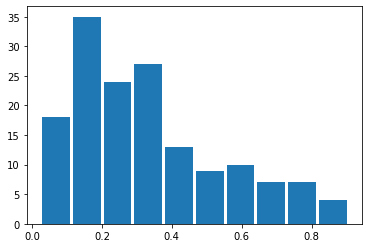

In [34]:
plt.hist(rslt_tbl['pred_val'], rwidth=0.9)
plt.hist

In [35]:
tmp_p = 0.3
tmp = (np.log(rslt_tbl['pred_val']+tmp_p)- np.log(tmp_p)) / (np.log(1+tmp_p)-np.log(tmp_p))

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)>

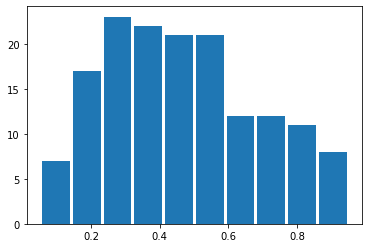

In [36]:
plt.hist(tmp, rwidth=0.9)
plt.hist

In [37]:
tmp

0      0.947909
1      0.308297
2      0.257639
3      0.679265
4      0.280370
         ...   
149    0.367873
150    0.241233
151    0.815263
152    0.240246
153    0.280100
Name: pred_val, Length: 154, dtype: float32

In [38]:
score = np.absolute(1000*tmp)

In [39]:
score

0      947.909119
1      308.296814
2      257.639404
3      679.265442
4      280.369568
          ...    
149    367.873352
150    241.233414
151    815.263123
152    240.246048
153    280.100311
Name: pred_val, Length: 154, dtype: float32

In [40]:
score = round(score)

In [41]:
score

0      948.0
1      308.0
2      258.0
3      679.0
4      280.0
       ...  
149    368.0
150    241.0
151    815.0
152    240.0
153    280.0
Name: pred_val, Length: 154, dtype: float32

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)>

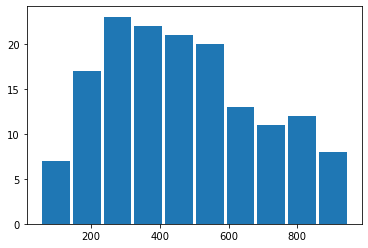

In [42]:
plt.hist(score, rwidth=0.9)
plt.hist

In [43]:
rslt_tbl['score'] = score
rslt_tbl['score'] = rslt_tbl['score'].astype(int) 
rslt_tbl

c:\anaconda\envs\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\anaconda\envs\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,rslt_y,pred_val,pred_class,score
0,1,0.904400,1,948
1,0,0.171467,0,308
2,0,0.137715,0,258
3,1,0.512255,1,679
4,0,0.152550,0,280
...,...,...,...,...
149,1,0.214507,0,368
150,0,0.127311,0,241
151,1,0.691514,1,815
152,0,0.126693,0,240


In [44]:
rslt_tbl

,rslt_y,pred_val,pred_class,score
0,1,0.904400,1,948
1,0,0.171467,0,308
2,0,0.137715,0,258
3,1,0.512255,1,679
4,0,0.152550,0,280
...,...,...,...,...
149,1,0.214507,0,368
150,0,0.127311,0,241
151,1,0.691514,1,815
152,0,0.126693,0,240


In [45]:
rslt_tbl['group'] = pd.qcut(rslt_tbl['score'], 10, labels=False)
rslt_tbl

c:\anaconda\envs\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,rslt_y,pred_val,pred_class,score,group
0,1,0.904400,1,948,9
1,0,0.171467,0,308,2
2,0,0.137715,0,258,2
3,1,0.512255,1,679,7
4,0,0.152550,0,280,2
...,...,...,...,...,...
149,1,0.214507,0,368,3
150,0,0.127311,0,241,1
151,1,0.691514,1,815,9
152,0,0.126693,0,240,1


In [46]:
grp_by_rslt = pd.DataFrame()

In [47]:
grp_by_rslt['grp_name'] = rslt_tbl['group'].unique()
grp_by_rslt

,grp_name
0,9
1,2
2,7
3,0
4,8
5,4
6,6
7,5
8,1
9,3


In [48]:
rslt_tbl.loc[rslt_tbl['group']==1,'pred_class']

13     0
28     0
32     0
46     0
56     0
78     0
110    0
116    0
118    0
131    0
140    0
146    0
148    0
150    0
152    0
Name: pred_class, dtype: int32

In [49]:
tmp_list = []
for i in grp_by_rslt['grp_name']:
    tmp = precision_recall_fscore_support(rslt_tbl.loc[rslt_tbl['group']==i,'rslt_y'], rslt_tbl.loc[rslt_tbl['group']==i,'pred_class'])
    tmp_list.append(tmp)
    
tmp_list

c:\anaconda\envs\python37\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[(array([0.   , 0.875]),
  array([0., 1.]),
  array([0.        , 0.93333333]),
  array([ 2, 14], dtype=int64)),
 (array([1.]), array([1.]), array([1.]), array([15], dtype=int64)),
 (array([0.41666667, 0.33333333]),
  array([0.71428571, 0.125     ]),
  array([0.52631579, 0.18181818]),
  array([7, 8], dtype=int64)),
 (array([1.]), array([1.]), array([1.]), array([16], dtype=int64)),
 (array([0.        , 0.73333333]),
  array([0., 1.]),
  array([0.        , 0.84615385]),
  array([ 4, 11], dtype=int64)),
 (array([0.93333333, 0.        ]),
  array([1., 0.]),
  array([0.96551724, 0.        ]),
  array([14,  1], dtype=int64)),
 (array([0.6875, 0.    ]),
  array([1., 0.]),
  array([0.81481481, 0.        ]),
  array([11,  5], dtype=int64)),
 (array([0.66666667, 0.        ]),
  array([1., 0.]),
  array([0.8, 0. ]),
  array([10,  5], dtype=int64)),
 (array([1.]), array([1.]), array([1.]), array([15], dtype=int64)),
 (array([0.8125, 0.    ]),
  array([1., 0.]),
  array([0.89655172, 0.        ]),
 

In [50]:
tmp_rslt = pd.DataFrame(tmp_list)
tmp_rslt.columns=['precision_0_1','recall_0_1','f_beta_score_0_1','support_0_1']
tmp_rslt

,precision_0_1,recall_0_1,f_beta_score_0_1,support_0_1
0,"[0.0, 0.875]","[0.0, 1.0]","[0.0, 0.9333333333333333]","[2, 14]"
1,[1.0],[1.0],[1.0],[15]
2,"[0.4166666666666667, 0.3333333333333333]","[0.7142857142857143, 0.125]","[0.5263157894736842, 0.18181818181818182]","[7, 8]"
3,[1.0],[1.0],[1.0],[16]
4,"[0.0, 0.7333333333333333]","[0.0, 1.0]","[0.0, 0.846153846153846]","[4, 11]"
5,"[0.9333333333333333, 0.0]","[1.0, 0.0]","[0.9655172413793104, 0.0]","[14, 1]"
6,"[0.6875, 0.0]","[1.0, 0.0]","[0.8148148148148148, 0.0]","[11, 5]"
7,"[0.6666666666666666, 0.0]","[1.0, 0.0]","[0.8, 0.0]","[10, 5]"
8,[1.0],[1.0],[1.0],[15]
9,"[0.8125, 0.0]","[1.0, 0.0]","[0.896551724137931, 0.0]","[13, 3]"


In [51]:
grp_by_rslt


,grp_name
0,9
1,2
2,7
3,0
4,8
5,4
6,6
7,5
8,1
9,3


In [52]:
total_grp_by_rslt = pd.concat([grp_by_rslt, tmp_rslt], axis=1)
total_grp_by_rslt

,grp_name,precision_0_1,recall_0_1,f_beta_score_0_1,support_0_1
0,9,"[0.0, 0.875]","[0.0, 1.0]","[0.0, 0.9333333333333333]","[2, 14]"
1,2,[1.0],[1.0],[1.0],[15]
2,7,"[0.4166666666666667, 0.3333333333333333]","[0.7142857142857143, 0.125]","[0.5263157894736842, 0.18181818181818182]","[7, 8]"
3,0,[1.0],[1.0],[1.0],[16]
4,8,"[0.0, 0.7333333333333333]","[0.0, 1.0]","[0.0, 0.846153846153846]","[4, 11]"
5,4,"[0.9333333333333333, 0.0]","[1.0, 0.0]","[0.9655172413793104, 0.0]","[14, 1]"
6,6,"[0.6875, 0.0]","[1.0, 0.0]","[0.8148148148148148, 0.0]","[11, 5]"
7,5,"[0.6666666666666666, 0.0]","[1.0, 0.0]","[0.8, 0.0]","[10, 5]"
8,1,[1.0],[1.0],[1.0],[15]
9,3,"[0.8125, 0.0]","[1.0, 0.0]","[0.896551724137931, 0.0]","[13, 3]"


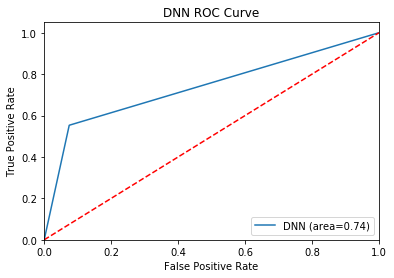

In [53]:
 
roc_auc = roc_auc_score(rslt_tbl['rslt_y'], rslt_tbl['pred_class'])
fpr, tpr, thresholds = roc_curve(rslt_tbl['rslt_y'], rslt_tbl['pred_class'])

plt.figure()
plt.plot(fpr, tpr, label='DNN (area=%0.2f)'%roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DNN ROC Curve')
plt.legend(loc='lower right')
plt.savefig('Log_ROC')
plt.show()

In [54]:
# sk_model = KerasClassifier(model)

In [55]:
# feature_rslt = permutation_importance(sk_model, X_test, y_test, n_repeats=10, random_state=SEED)